# Psychology of a Professional Athlete
In this script we explore all shot attempts of Kobe Bryant throughout his career and try to see if Kobe displays the "hot hand" effect

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Circle, Rectangle, Arc
from sklearn import mixture
from sklearn import ensemble
from sklearn import model_selection
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import log_loss
import time
import itertools
import operator

## Load the data and create some useful fields
show the newly created fields as a sanity check

In [2]:
#%% load training data
allData = pd.read_csv('../input/data.csv')
data = allData[allData['shot_made_flag'].notnull()].reset_index()

#%% add some temporal columns to the data
data['game_date_DT'] = pd.to_datetime(data['game_date'])
data['dayOfWeek']    = data['game_date_DT'].dt.dayofweek
data['dayOfYear']    = data['game_date_DT'].dt.dayofyear

data['secondsFromPeriodEnd']   = 60*data['minutes_remaining']+data['seconds_remaining']
data['secondsFromPeriodStart'] = 60*(11-data['minutes_remaining'])+(60-data['seconds_remaining'])
data['secondsFromGameStart']   = (data['period'] <= 4).astype(int)*(data['period']-1)*12*60 + (data['period'] > 4).astype(int)*((data['period']-4)*5*60 + 3*12*60) + data['secondsFromPeriodStart']

# look at first couple of rows and verify that everything is good
data.loc[:10,['period','minutes_remaining','seconds_remaining','secondsFromGameStart']]

,period,minutes_remaining,seconds_remaining,secondsFromGameStart
0,1,10,22,98
1,1,7,45,255
2,1,6,52,308
3,2,6,19,1061
4,3,9,32,1588
5,3,8,52,1628
6,3,6,12,1788
7,3,3,36,1944
8,3,1,56,2044
9,1,11,0,60


## Plot Shot Attempts as a function of time during the game
here we apply 3 different binnings of time and show the attempts as function from game start

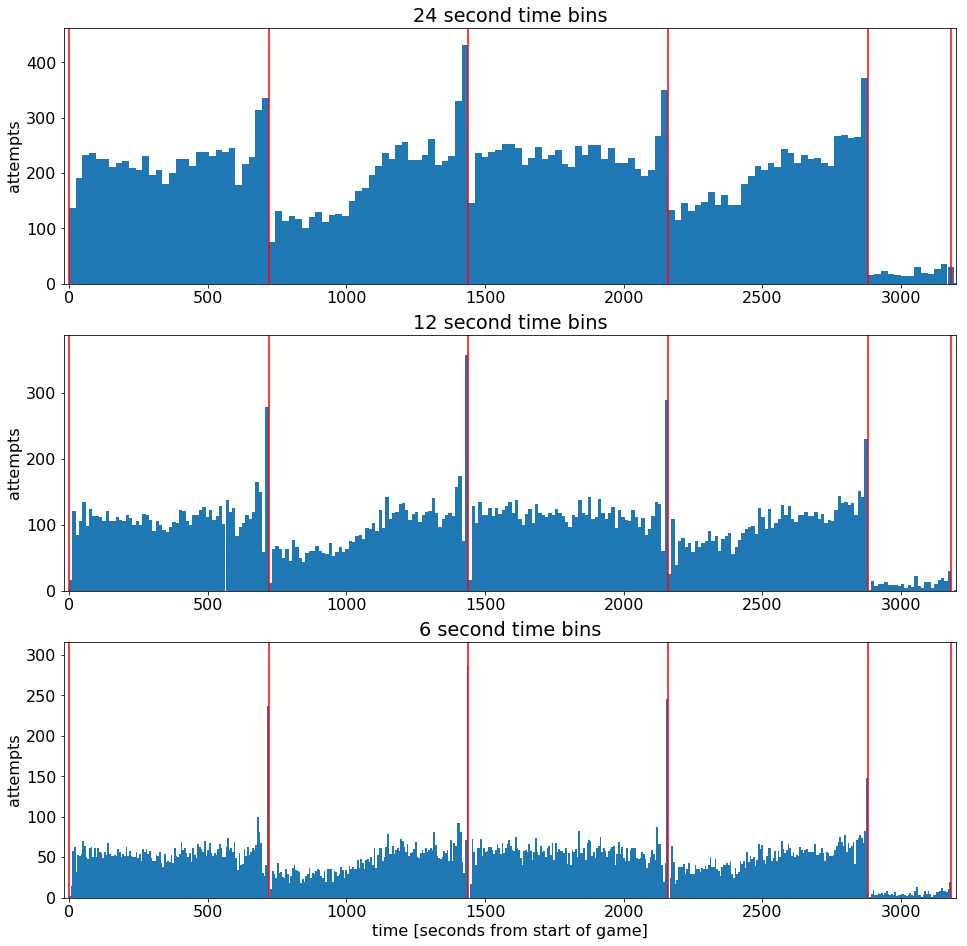

In [3]:
# plot the shot attempts as a function of time (from start of game) with several different binnings
plt.rcParams['figure.figsize'] = (16, 16)
plt.rcParams['font.size'] = 16

binsSizes = [24,12,6]

plt.figure();
for k, binSizeInSeconds in enumerate(binsSizes):
    timeBins = np.arange(0,60*(4*12+3*5),binSizeInSeconds)+0.01
    attemptsAsFunctionOfTime, b = np.histogram(data['secondsFromGameStart'], bins=timeBins)     
    
    maxHeight = max(attemptsAsFunctionOfTime) + 30
    barWidth = 0.999*(timeBins[1]-timeBins[0])
    plt.subplot(len(binsSizes),1,k+1); 
    plt.bar(timeBins[:-1],attemptsAsFunctionOfTime, align='edge', width=barWidth); plt.title(str(binSizeInSeconds) + ' second time bins')
    plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0,ymax=maxHeight, colors='r')
    plt.xlim((-20,3200)); plt.ylim((0,maxHeight)); plt.ylabel('attempts')
plt.xlabel('time [seconds from start of game]')

### It looks like Kobe is entrusted to take the last shot of every period
it also looks like he's usually on the bench at the start of 2nd and 4th periods

## Plot Shot Accuracy as function of time during the game

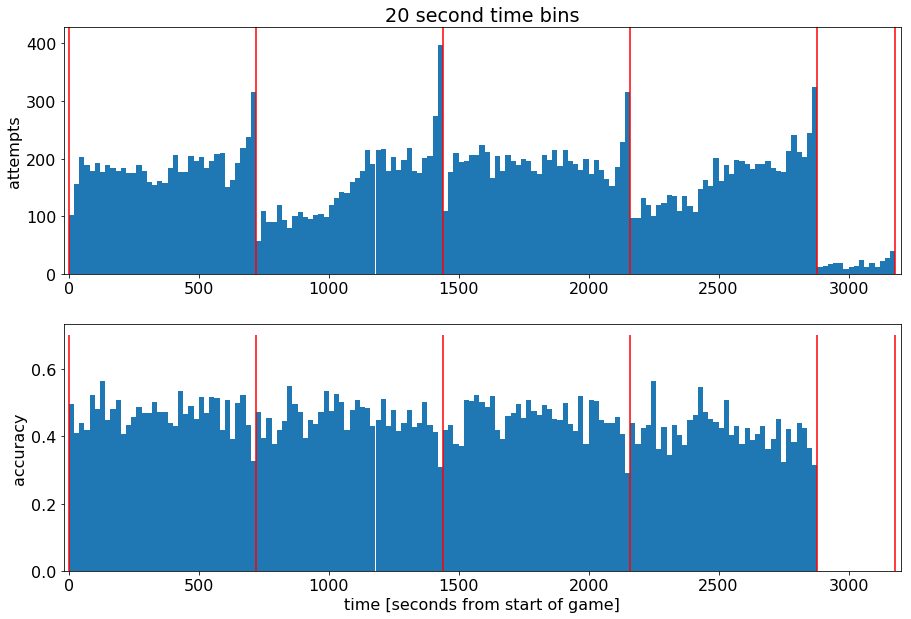

In [4]:
#%% plot the accuracy as a function of time
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 16

binSizeInSeconds = 20
timeBins = np.arange(0,60*(4*12+3*5),binSizeInSeconds)+0.01
attemptsAsFunctionOfTime,     b = np.histogram(data['secondsFromGameStart'], bins=timeBins)     
madeAttemptsAsFunctionOfTime, b = np.histogram(data.loc[data['shot_made_flag']==1,'secondsFromGameStart'], bins=timeBins)     
attemptsAsFunctionOfTime[attemptsAsFunctionOfTime < 1] = 1
accuracyAsFunctionOfTime = madeAttemptsAsFunctionOfTime.astype(float)/attemptsAsFunctionOfTime
accuracyAsFunctionOfTime[attemptsAsFunctionOfTime <= 50] = 0 # zero accuracy in bins that don't have enough samples

maxHeight = max(attemptsAsFunctionOfTime) + 30
barWidth = 0.999*(timeBins[1]-timeBins[0])

plt.figure();
plt.subplot(2,1,1); plt.bar(timeBins[:-1],attemptsAsFunctionOfTime, align='edge', width=barWidth); 
plt.xlim((-20,3200)); plt.ylim((0,maxHeight)); plt.ylabel('attempts'); plt.title(str(binSizeInSeconds) + ' second time bins')
plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0,ymax=maxHeight, colors='r')
plt.subplot(2,1,2); plt.bar(timeBins[:-1],accuracyAsFunctionOfTime, align='edge', width=barWidth); 
plt.xlim((-20,3200)); plt.ylabel('accuracy'); plt.xlabel('time [seconds from start of game]')
plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0.0,ymax=0.7, colors='r')

### Note that the accuracy of these "last second shots" is consisently lower than usuall
This is probably due to the fact that a large amonut of these shots are from very far away

## Now let's continue our initial exploration and examine the spatial location aspect of kobe's shots
we'll do this by building a **gaussian mixture model** that tries to summerize Kobe's shot locations compactly

In [5]:
#%% cluster the shot attempts of kobe using GMM on their location
numGaussians = 13
gaussianMixtureModel = mixture.GaussianMixture(n_components=numGaussians, covariance_type='full', 
                                               init_params='kmeans', n_init=50, 
                                               verbose=0, random_state=5)
gaussianMixtureModel.fit(data.loc[:,['loc_x','loc_y']])

# add the GMM cluster as a field in the dataset
data['shotLocationCluster'] = gaussianMixtureModel.predict(data.loc[:,['loc_x','loc_y']])

## Define some helper functions
the function **draw_court()** is shamelessly stolen from **[MichaelKrueger](https://www.kaggle.com/bbx396)**'s excelent [script](https://www.kaggle.com/bbx396/kobechart))

In [6]:
#%% define draw functions (stealing shamelessly the draw_court() function from MichaelKrueger's excelent script)

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

def Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages):
    
    fig, h = plt.subplots();
    for i, (mean, covarianceMatrix) in enumerate(zip(gaussianMixtureModel.means_, gaussianMixtureModel.covariances_)):
        # get the eigen vectors and eigen values of the covariance matrix
        v, w = np.linalg.eigh(covarianceMatrix)
        v = 2.5*np.sqrt(v) # go to units of standard deviation instead of variance
        
        # calculate the ellipse angle and two axis length and draw it
        u = w[0] / np.linalg.norm(w[0])    
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        currEllipse = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=ellipseColors[i])
        currEllipse.set_alpha(0.5)
        h.add_artist(currEllipse)
        h.text(mean[0]+7, mean[1]-1, ellipseTextMessages[i], fontsize=13, color='blue')


## Draw the 2D Gaussians of Shot Attempts
Each elipse is the countour that represents 2.5 standard deviations away from the center of the gaussian
Each number in blue represents the precent of shots taken from this gaussian out of all shots

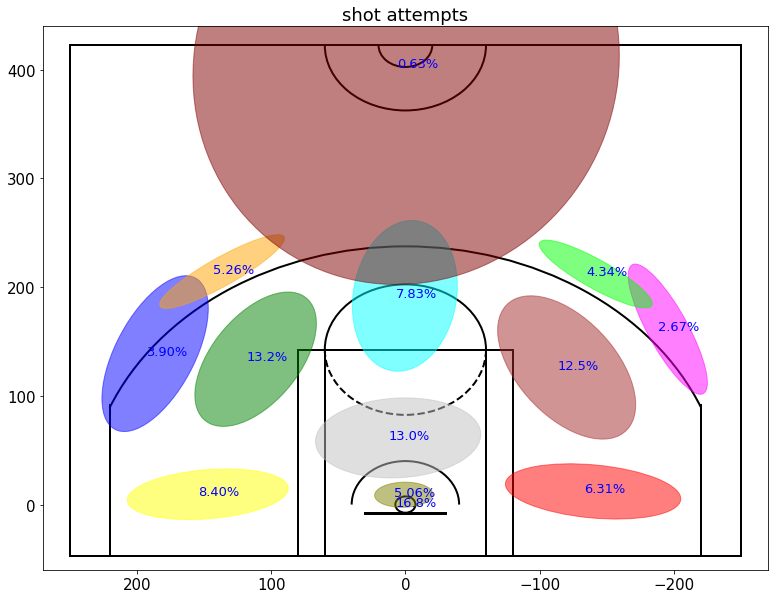

In [7]:
#%% show gaussian mixture elipses of shot attempts
plt.rcParams['figure.figsize'] = (13, 10)
plt.rcParams['font.size'] = 15

ellipseTextMessages = [str(100*gaussianMixtureModel.weights_[x])[:4]+'%' for x in range(numGaussians)]
ellipseColors = ['red','green','purple','cyan','magenta','yellow','blue','orange','silver','maroon','lime','olive','brown','darkblue']
Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages)
draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270); plt.title('shot attempts')

We can see that Kobe is making **more attempts** from the **left side** of the court (or right side from his point of view). this is probably because he's **right handed**.

Also, we can see that a huge number of attempts (16.8%) is from directly under the basket, and 5.06% additinal attemps are from very close to the basket


## Show the Scatter Plot of all Kobe's shot attempts colored by the cluster assignment according to the GMM

Just to make sure the gaussian model actually captures something

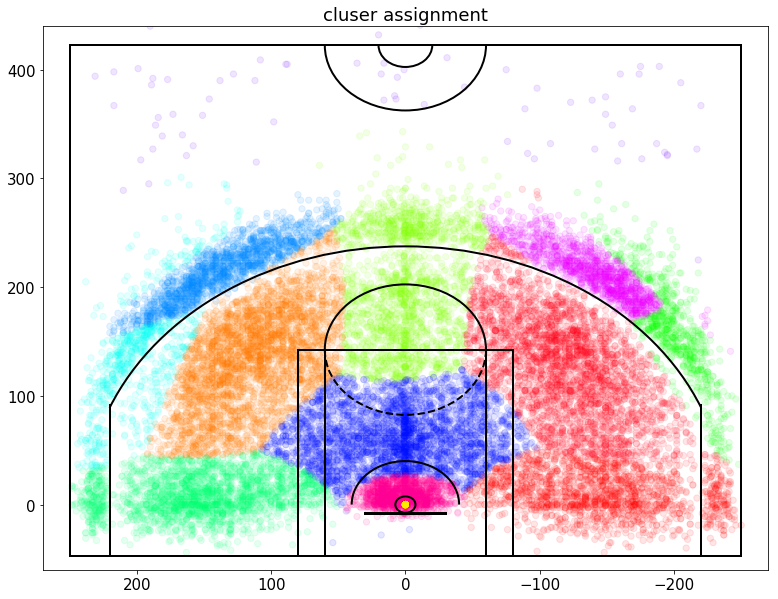

In [8]:
#%% just to make sure the gaussian model actually captures something, show the scatter and cluster assignment
plt.rcParams['figure.figsize'] = (13, 10)
plt.rcParams['font.size'] = 15

plt.figure(); draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270); plt.title('cluser assignment')
plt.scatter(x=data['loc_x'],y=data['loc_y'],c=data['shotLocationCluster'],s=40,cmap='hsv',alpha=0.1)

It doesn't seem perfect, but definatly captures some interesting things about the data
for example, we can see that the large and very far away cluster is capturing all of the very distant shots

## Plot the Shot Accuracy of each Gaussian Cluster 
Each blue number here will represent the accuracy of the shots taken from this cluster so we can get a feel for what are easy and what are difficult shots

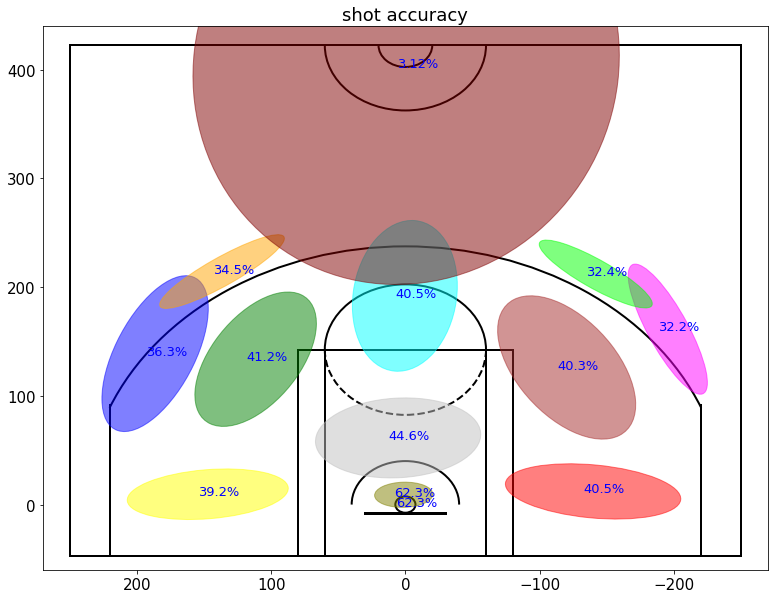

In [9]:
#%% for each cluster, calculate it's individual accuracy and plot it
plt.rcParams['figure.figsize'] = (13, 10)
plt.rcParams['font.size'] = 15

variableCategories = data['shotLocationCluster'].value_counts().index.tolist()

clusterAccuracy = {}
for category in variableCategories:
    shotsAttempted = np.array(data['shotLocationCluster'] == category).sum()
    shotsMade = np.array(data.loc[data['shotLocationCluster'] == category,'shot_made_flag'] == 1).sum()
    clusterAccuracy[category] = float(shotsMade)/shotsAttempted

ellipseTextMessages = [str(100*clusterAccuracy[x])[:4]+'%' for x in range(numGaussians)]
Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages)
draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270); plt.title('shot accuracy')

### We can clearly see the dependence between distance and accuracy
Another interesting fact is that Kobe not only makes more attempts from the right side (from his point of view), but also he's better at making those attempts

## Now let's Plot a 2D Spatio-Temporal plot of Kobe's career

* on **x-axis** there will be **time** since start of game
* on **y-axis** there will be the **cluster index** Kobe made the shot (sorted by the cluster accuracy)
* the **intensity** will be the **number of attempts** by Kobe from that particular cluster at that particular time
* red verticle lines are the end of each period

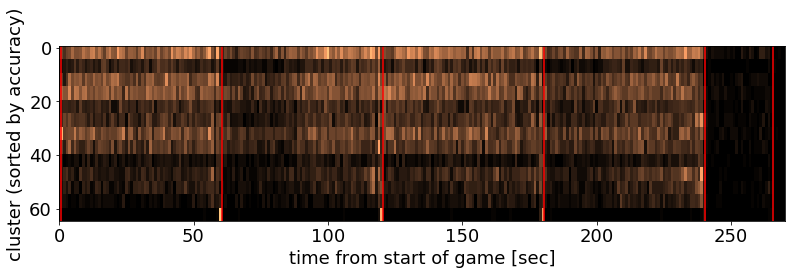

In [10]:
#%% plot a 2-d spatio-temporal histogram of kobe's games during his entire carrer
plt.rcParams['figure.figsize'] = (18, 10)
plt.rcParams['font.size'] = 18

# sort the clusters according to their accuracy
sortedClustersByAccuracyTuple = sorted(clusterAccuracy.items(), key=operator.itemgetter(1),reverse=True)
sortedClustersByAccuracy = [x[0] for x in sortedClustersByAccuracyTuple]

binSizeInSeconds = 12
timeInUnitsOfBins = ((data['secondsFromGameStart']+0.0001)/binSizeInSeconds).astype(int)
locationInUintsOfClusters = np.array([sortedClustersByAccuracy.index(data.loc[x,'shotLocationCluster']) for x in range(data.shape[0])])

# build a spatio-temporal histogram of Kobe's games
shotAttempts = np.zeros((gaussianMixtureModel.n_components,1+max(timeInUnitsOfBins)))
for shot in range(data.shape[0]):
    shotAttempts[locationInUintsOfClusters[shot],timeInUnitsOfBins[shot]] += 1

# make the y-axis have larger area so it will be more visible 
shotAttempts = np.kron(shotAttempts,np.ones((5,1)))
# the locations of the period ends
vlinesList = 0.5001+np.array([0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60]).astype(int)/binSizeInSeconds

plt.figure(figsize=(13,8))
plt.imshow(shotAttempts, cmap='copper',interpolation="nearest"); plt.xlim(0,float(4*12*60+6*60)/binSizeInSeconds);
plt.vlines(x=vlinesList, ymin=-0.5,ymax=shotAttempts.shape[0]-0.5, colors='r');
plt.xlabel('time from start of game [sec]'); plt.ylabel('cluster (sorted by accuracy)')

The clusters are sorted in descending order of accuracy. under the basek high accuracy shots are at the top, and low accuracy shots from half court are at the bottom
### We can now see that the "last second shots" in the 1st, 2nd and 3rd periods were indeed "hopeless shots" from very far away
It's interesting to note, however, that in the 4th period, the last second shot don't belong to the "hopeless" cluster, but rather to the regular 3-pointer clusters (which are still much more difficult, but not hopeless)


## For later analysis, we'll want to assess shot difficulty based on shot properties
(such as shot type and shot distance)

In [11]:
#%% create a new table for shot difficulty model
def FactorizeCategoricalVariable(inputDB,categoricalVarName):
    opponentCategories = inputDB[categoricalVarName].value_counts().index.tolist()
    
    outputDB = pd.DataFrame()
    for category in opponentCategories:
        featureName = categoricalVarName + ': ' + str(category)
        outputDB[featureName] = (inputDB[categoricalVarName] == category).astype(int)

    return outputDB

featuresDB = pd.DataFrame()
featuresDB['homeGame'] = data['matchup'].apply(lambda x: 1 if (x.find('@') < 0) else 0)
featuresDB = pd.concat([featuresDB,FactorizeCategoricalVariable(data,'opponent')],axis=1)
featuresDB = pd.concat([featuresDB,FactorizeCategoricalVariable(data,'action_type')],axis=1)
featuresDB = pd.concat([featuresDB,FactorizeCategoricalVariable(data,'shot_type')],axis=1)
featuresDB = pd.concat([featuresDB,FactorizeCategoricalVariable(data,'combined_shot_type')],axis=1)
featuresDB = pd.concat([featuresDB,FactorizeCategoricalVariable(data,'shot_zone_basic')],axis=1)
featuresDB = pd.concat([featuresDB,FactorizeCategoricalVariable(data,'shot_zone_area')],axis=1)
featuresDB = pd.concat([featuresDB,FactorizeCategoricalVariable(data,'shot_zone_range')],axis=1)
featuresDB = pd.concat([featuresDB,FactorizeCategoricalVariable(data,'shotLocationCluster')],axis=1)

featuresDB['playoffGame']          = data['playoffs']
featuresDB['locX']                 = data['loc_x']
featuresDB['locY']                 = data['loc_y']
featuresDB['distanceFromBasket']   = data['shot_distance']
featuresDB['secondsFromPeriodEnd'] = data['secondsFromPeriodEnd']

featuresDB['dayOfWeek_cycX']  = np.sin(2*np.pi*(data['dayOfWeek']/7))
featuresDB['dayOfWeek_cycY']  = np.cos(2*np.pi*(data['dayOfWeek']/7))
featuresDB['timeOfYear_cycX'] = np.sin(2*np.pi*(data['dayOfYear']/365))
featuresDB['timeOfYear_cycY'] = np.cos(2*np.pi*(data['dayOfYear']/365))

labelsDB = data['shot_made_flag']

## Build a model based on featuresDB table, and make sure it doesn't overfit 
(i.e. the training error and the test error are the same)
#### Use an ExtraTreesClassifier for that

In [12]:
#%% build a simple model and make sure it doesnt overfit
randomSeed = 1
numFolds   = 4

stratifiedCV = model_selection.StratifiedKFold(n_splits=numFolds, shuffle=True, random_state=randomSeed)

mainLearner = ensemble.ExtraTreesClassifier(n_estimators=500, max_depth=5, 
                                            min_samples_leaf=120, max_features=120, 
                                            criterion='entropy', bootstrap=False, 
                                            n_jobs=-1, random_state=randomSeed)

startTime = time.time()
trainAccuracy = []; validAccuracy = [];
trainLogLosses = []; validLogLosses = []
for trainInds, validInds in stratifiedCV.split(featuresDB, labelsDB):
    # split to train and valid sets
    X_train_CV = featuresDB.iloc[trainInds,:]
    y_train_CV = labelsDB.iloc[trainInds]
    X_valid_CV = featuresDB.iloc[validInds,:]
    y_valid_CV = labelsDB.iloc[validInds]
    
    # train learner
    mainLearner.fit(X_train_CV, y_train_CV)
    
    # make predictions
    y_train_hat_mainLearner = mainLearner.predict_proba(X_train_CV)[:,1]
    y_valid_hat_mainLearner = mainLearner.predict_proba(X_valid_CV)[:,1]

    # store results
    trainAccuracy.append(accuracy(y_train_CV, y_train_hat_mainLearner > 0.5))
    validAccuracy.append(accuracy(y_valid_CV, y_valid_hat_mainLearner > 0.5))
    trainLogLosses.append(log_loss(y_train_CV, y_train_hat_mainLearner))
    validLogLosses.append(log_loss(y_valid_CV, y_valid_hat_mainLearner))

print("-----------------------------------------------------")
print("total (train,valid) Accuracy = (%.5f,%.5f). took %.2f minutes" % (np.mean(trainAccuracy),np.mean(validAccuracy), (time.time()-startTime)/60))
print("total (train,valid) Log Loss = (%.5f,%.5f). took %.2f minutes" % (np.mean(trainLogLosses),np.mean(validLogLosses), (time.time()-startTime)/60))
print("-----------------------------------------------------")

-----------------------------------------------------
total (train,valid) Accuracy = (0.67908,0.67876). took 0.48 minutes
total (train,valid) Log Loss = (0.60812,0.61069). took 0.48 minutes
-----------------------------------------------------


### Use the model to add a "shotDifficulty" field to every original shot entry
(which is actually the predicted probability of making the shot. meaning, the name is a bit confusing right now)



In [13]:
mainLearner.fit(featuresDB, labelsDB)
data['shotDifficulty'] = mainLearner.predict_proba(featuresDB)[:,1]

## Get a feel for the important features of this model
look at the feature importances according to ET Classifier

In [14]:
# just to get a feel for what determins shot difficulty, look at feature importances
featureInds = mainLearner.feature_importances_.argsort()[::-1]
featureImportance = pd.DataFrame(np.concatenate((featuresDB.columns[featureInds,None], mainLearner.feature_importances_[featureInds,None]), axis=1),
                                  columns=['featureName', 'importanceET'])

featureImportance.iloc[:30,:]

,featureName,importanceET
0,action_type: Jump Shot,0.578965
1,action_type: Layup Shot,0.174299
2,combined_shot_type: Dunk,0.113124
3,homeGame,0.0291337
4,action_type: Dunk Shot,0.0163483
5,shotLocationCluster: 9,0.0145711
6,combined_shot_type: Layup,0.00994704
7,distanceFromBasket,0.00767911
8,shot_zone_range: 16-24 ft.,0.00767593
9,action_type: Slam Dunk Shot,0.00676747


# We would like to asses some aspects of the decision making process of Kobe Bryant
### For that we will collect two distinct groups of shots and analyse the differences between them:

1. The shots that came right **after a sucessful shot** attempt
1. The shots that came right **after a missed shot** attempt

In [15]:
#%% collect data given that kobe made or missed last shot
timeBetweenShotsDict = {}
timeBetweenShotsDict['madeLast']   = []
timeBetweenShotsDict['missedLast'] = []

changeInDistFromBasketDict = {}
changeInDistFromBasketDict['madeLast']   = []
changeInDistFromBasketDict['missedLast'] = []

changeInShotDifficultyDict = {}
changeInShotDifficultyDict['madeLast']   = []
changeInShotDifficultyDict['missedLast'] = []

afterMadeShotsList   = []
afterMissedShotsList = []

for shot in range(1,data.shape[0]):

    # make sure the current shot and last shot were all in the same period of the same game
    sameGame   = data.loc[shot,'game_date'] == data.loc[shot-1,'game_date']
    samePeriod = data.loc[shot,'period']    == data.loc[shot-1,'period']

    if samePeriod and sameGame:
        madeLastShot       = data.loc[shot-1,'shot_made_flag'] == 1
        missedLastShot     = data.loc[shot-1,'shot_made_flag'] == 0
        
        timeDifferenceFromLastShot = data.loc[shot,'secondsFromGameStart']     - data.loc[shot-1,'secondsFromGameStart']
        distDifferenceFromLastShot = data.loc[shot,'shot_distance']            - data.loc[shot-1,'shot_distance']
        shotDifficultyDifferenceFromLastShot = data.loc[shot,'shotDifficulty'] - data.loc[shot-1,'shotDifficulty']

        # check for currupt data points (assuming all samples should have been chronologically ordered)
        if timeDifferenceFromLastShot < 0:
            continue
        
        if madeLastShot:
            timeBetweenShotsDict['madeLast'].append(timeDifferenceFromLastShot)
            changeInDistFromBasketDict['madeLast'].append(distDifferenceFromLastShot)
            changeInShotDifficultyDict['madeLast'].append(shotDifficultyDifferenceFromLastShot)
            afterMadeShotsList.append(shot)
            
        if missedLastShot:
            timeBetweenShotsDict['missedLast'].append(timeDifferenceFromLastShot)
            changeInDistFromBasketDict['missedLast'].append(distDifferenceFromLastShot)
            changeInShotDifficultyDict['missedLast'].append(shotDifficultyDifferenceFromLastShot)
            afterMissedShotsList.append(shot)

afterMissedData = data.iloc[afterMissedShotsList,:]
afterMadeData   = data.iloc[afterMadeShotsList,:]

shotChancesListAfterMade = afterMadeData['shotDifficulty'].tolist()
totalAttemptsAfterMade   = afterMadeData.shape[0]
totalMadeAfterMade       = np.array(afterMadeData['shot_made_flag'] == 1).sum()

shotChancesListAfterMissed = afterMissedData['shotDifficulty'].tolist()
totalAttemptsAfterMissed   = afterMissedData.shape[0]
totalMadeAfterMissed       = np.array(afterMissedData['shot_made_flag'] == 1).sum()

## Plot histogram of "Time Since Last Shot Attempt" for the two groups

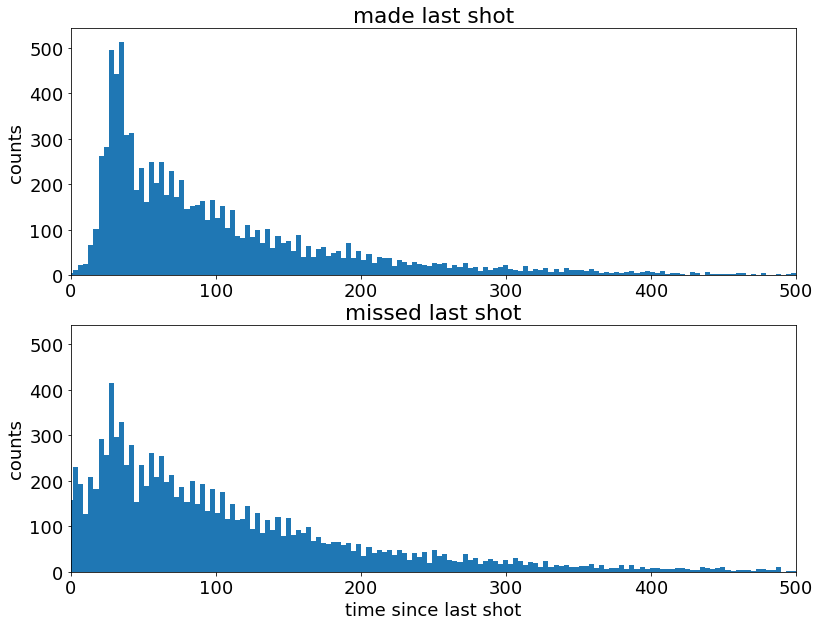

In [16]:
#%% after making a shot, kobe wants more
plt.rcParams['figure.figsize'] = (13, 10)

jointHist, timeBins = np.histogram(timeBetweenShotsDict['madeLast']+timeBetweenShotsDict['missedLast'],bins=200)
barWidth = 0.999*(timeBins[1]-timeBins[0])

timeDiffHist_GivenMadeLastShot, b = np.histogram(timeBetweenShotsDict['madeLast'],bins=timeBins)
timeDiffHist_GivenMissedLastShot, b = np.histogram(timeBetweenShotsDict['missedLast'],bins=timeBins)
maxHeight = max(max(timeDiffHist_GivenMadeLastShot),max(timeDiffHist_GivenMissedLastShot)) + 30

plt.figure();
plt.subplot(2,1,1); plt.bar(timeBins[:-1], timeDiffHist_GivenMadeLastShot, width=barWidth); plt.xlim((0,500)); plt.ylim((0,maxHeight))
plt.title('made last shot'); plt.ylabel('counts')
plt.subplot(2,1,2); plt.bar(timeBins[:-1], timeDiffHist_GivenMissedLastShot, width=barWidth); plt.xlim((0,500)); plt.ylim((0,maxHeight))
plt.title('missed last shot'); plt.xlabel('time since last shot'); plt.ylabel('counts')

It looks like after making a shot, kobe is a little bit more eager to throw the next shot
### To everyone who is wondering about why is there a "silent period" after a made shot:
it's most likely because the ball is transfered to the other team after a sucesfull shot and it takes some time to get the ball back

## To better visualize this difference between the histograms, let's look at cumulative histograms

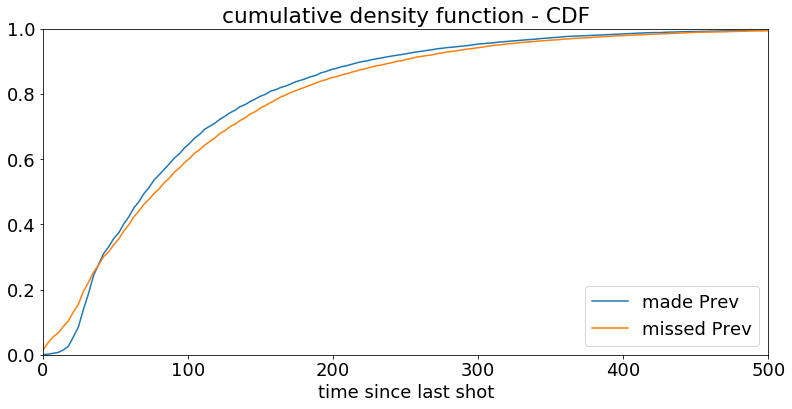

In [17]:
#%% to make the difference clearer, show the cumulative histogram
plt.rcParams['figure.figsize'] = (13, 6)

timeDiffCumHist_GivenMadeLastShot = np.cumsum(timeDiffHist_GivenMadeLastShot).astype(float)
timeDiffCumHist_GivenMadeLastShot = timeDiffCumHist_GivenMadeLastShot/max(timeDiffCumHist_GivenMadeLastShot)
timeDiffCumHist_GivenMissedLastShot = np.cumsum(timeDiffHist_GivenMissedLastShot).astype(float)
timeDiffCumHist_GivenMissedLastShot = timeDiffCumHist_GivenMissedLastShot/max(timeDiffCumHist_GivenMissedLastShot)

maxHeight = max(timeDiffCumHist_GivenMadeLastShot[-1],timeDiffCumHist_GivenMissedLastShot[-1])

plt.figure();
madePrev = plt.plot(timeBins[:-1], timeDiffCumHist_GivenMadeLastShot, label='made Prev'); plt.xlim((0,500))
missedPrev = plt.plot(timeBins[:-1], timeDiffCumHist_GivenMissedLastShot, label='missed Prev'); plt.xlim((0,500)); plt.ylim((0,1))
plt.title('cumulative density function - CDF'); plt.xlabel('time since last shot'); plt.legend(loc='lower right')

## Plot histogram of "Current Shot Distance - Previous Shot Distance" for the two groups
Note that if Kobe throws from close by, and then from far away, this will result in positive values of "curr shot distance - prev shot distance". and vise versa - If Kobe throws from far away and then from close by, this will result in negative values.

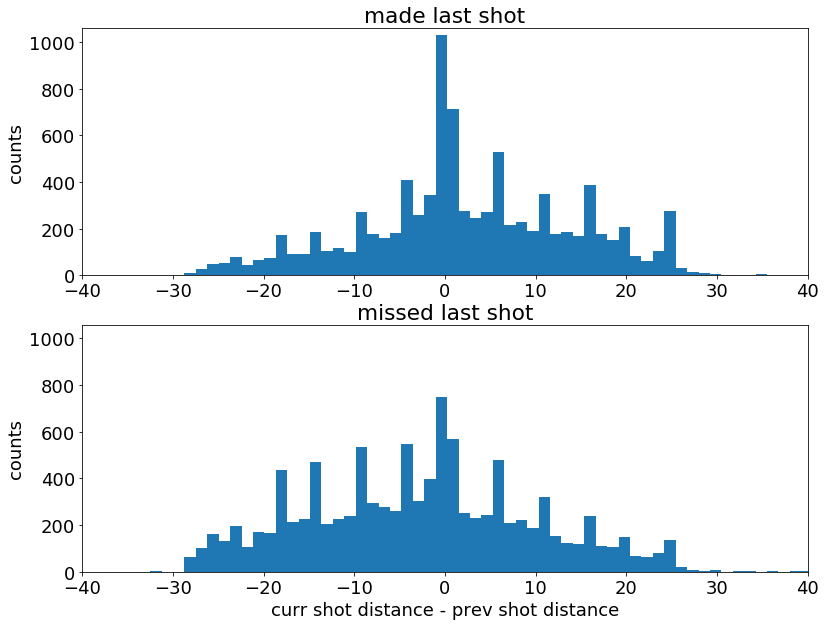

In [18]:
#%% after making a shot, kobe is a more confident and throws from further away
plt.rcParams['figure.figsize'] = (13, 10)

jointHist, distDiffBins = np.histogram(changeInDistFromBasketDict['madeLast']+changeInDistFromBasketDict['missedLast'],bins=100,density=False)
barWidth = 0.999*(distDiffBins[1]-distDiffBins[0])

distDiffHist_GivenMadeLastShot,   b = np.histogram(changeInDistFromBasketDict['madeLast'],bins=distDiffBins)
distDiffHist_GivenMissedLastShot, b = np.histogram(changeInDistFromBasketDict['missedLast'],bins=distDiffBins)
maxHeight = max(max(distDiffHist_GivenMadeLastShot),max(distDiffHist_GivenMissedLastShot)) + 30

plt.figure();
plt.subplot(2,1,1); plt.bar(distDiffBins[:-1], distDiffHist_GivenMadeLastShot, width=barWidth); plt.xlim((-40,40)); plt.ylim((0,maxHeight))
plt.title('made last shot'); plt.ylabel('counts')
plt.subplot(2,1,2); plt.bar(distDiffBins[:-1], distDiffHist_GivenMissedLastShot, width=barWidth); plt.xlim((-40,40)); plt.ylim((0,maxHeight))
plt.title('missed last shot'); plt.xlabel('curr shot distance - prev shot distance'); plt.ylabel('counts')

We can clearly see that the made group of shots is more leaning to the right
### It therefore looks like Kobe is more confident after making a shot, and because of it, he takes a larger risk and throws from further away
This is even more evident than the previous plot, but let's plot the cumulative histograms again to make it clearer

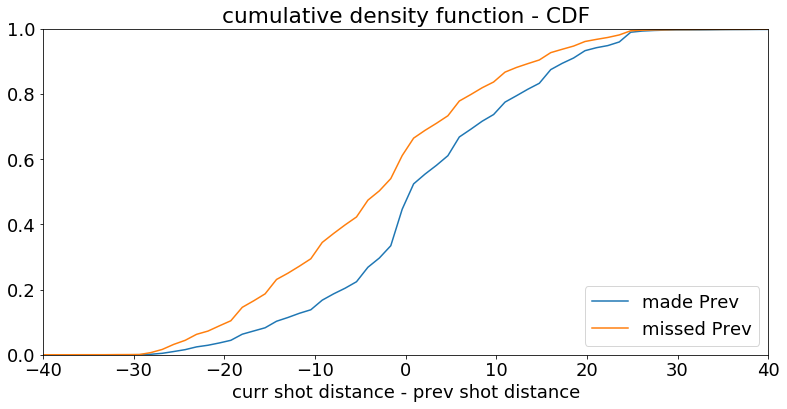

In [19]:
#%% to make the difference clearer, show the cumulative histogram
plt.rcParams['figure.figsize'] = (13, 6)

distDiffCumHist_GivenMadeLastShot = np.cumsum(distDiffHist_GivenMadeLastShot).astype(float)
distDiffCumHist_GivenMadeLastShot = distDiffCumHist_GivenMadeLastShot/max(distDiffCumHist_GivenMadeLastShot)
distDiffCumHist_GivenMissedLastShot = np.cumsum(distDiffHist_GivenMissedLastShot).astype(float)
distDiffCumHist_GivenMissedLastShot = distDiffCumHist_GivenMissedLastShot/max(distDiffCumHist_GivenMissedLastShot)

maxHeight = max(distDiffCumHist_GivenMadeLastShot[-1],distDiffCumHist_GivenMissedLastShot[-1])

plt.figure();
madePrev = plt.plot(distDiffBins[:-1], distDiffCumHist_GivenMadeLastShot, label='made Prev'); plt.xlim((-40,40))
missedPrev = plt.plot(distDiffBins[:-1], distDiffCumHist_GivenMissedLastShot, label='missed Prev'); plt.xlim((-40,40)); plt.ylim((0,1))
plt.title('cumulative density function - CDF'); plt.xlabel('curr shot distance - prev shot distance'); plt.legend(loc='lower right')

## Lastly, Let's plot the "Shot Difficulty" change for the two groups
here negative values indicate that kobe took a larger risk, and positive values indicate that kobe made a safer subsequent shot

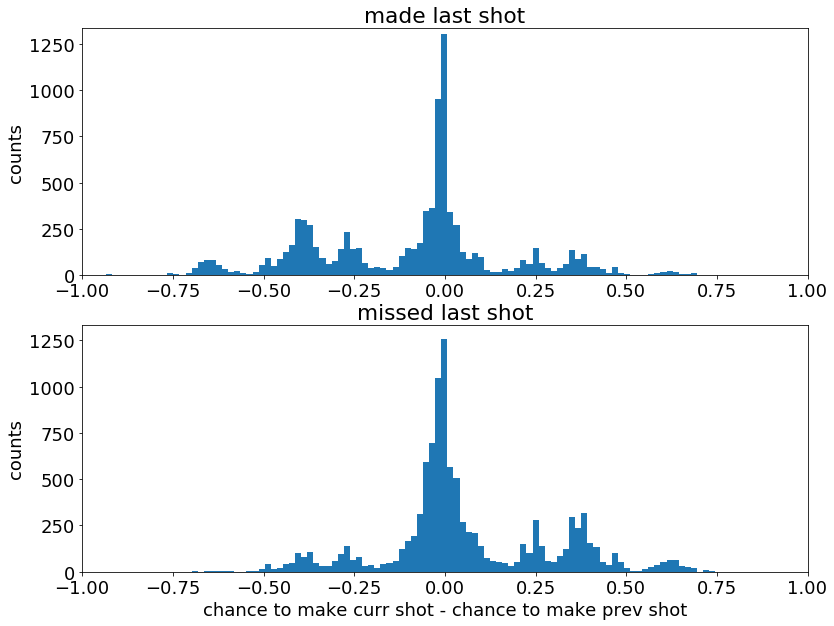

In [20]:
#%% after making a shot, kobe is a more confident and makes much more difficult shots generally
plt.rcParams['figure.figsize'] = (13, 10)

jointHist, difficultyDiffBins = np.histogram(changeInShotDifficultyDict['madeLast']+changeInShotDifficultyDict['missedLast'],bins=100)
barWidth = 0.999*(difficultyDiffBins[1]-difficultyDiffBins[0])

shotDifficultyDiffHist_GivenMadeLastShot,   b = np.histogram(changeInShotDifficultyDict['madeLast'],bins=difficultyDiffBins)
shotDifficultyDiffHist_GivenMissedLastShot, b = np.histogram(changeInShotDifficultyDict['missedLast'],bins=difficultyDiffBins)
maxHeight = max(max(shotDifficultyDiffHist_GivenMadeLastShot),max(shotDifficultyDiffHist_GivenMissedLastShot)) + 30

plt.figure();
plt.subplot(2,1,1); plt.bar(difficultyDiffBins[:-1], shotDifficultyDiffHist_GivenMadeLastShot, width=barWidth); plt.xlim((-1,1)); plt.ylim((0,maxHeight))
plt.title('made last shot'); plt.ylabel('counts')
plt.subplot(2,1,2); plt.bar(difficultyDiffBins[:-1], shotDifficultyDiffHist_GivenMissedLastShot, width=barWidth); plt.xlim((-1,1)); plt.ylim((0,maxHeight))
plt.title('missed last shot'); plt.xlabel('chance to make curr shot - chance to make prev shot'); plt.ylabel('counts')

### We can see that the plot is heavier on the left side
### It is therefore even more evident now that kobe feels he's "In The Zone" after making a shot 
and therefore he allows himself to attempt more difficult shots

## Some of you might be wondering about wheather it's simply regression to the mean or not
this thinking is sound, since all successful attempts are inherently biased towards easier shots, and if we use relative meassures such as "shot difficulty change" we will for sure get this effect by simply "going back to the mean", so we need to make sure this isn't it.

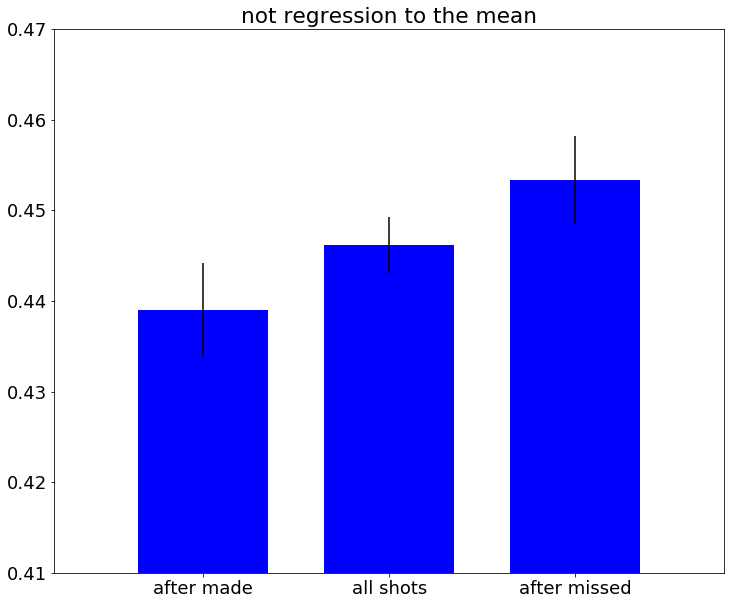

In [21]:
#%% is this regression to the mean?
plt.rcParams['figure.figsize'] = (12, 10)

accuracyAllShots    = data['shot_made_flag'].mean()
accuracyAfterMade   = afterMadeData['shot_made_flag'].mean()
accuracyAfterMissed = afterMissedData['shot_made_flag'].mean()

standardErrorAllShots    = np.sqrt(accuracyAllShots*(1-accuracyAllShots)/data.shape[0])
standardErrorAfterMade   = np.sqrt(accuracyAfterMade*(1-accuracyAfterMade)/afterMadeData.shape[0])
standardErrorAfterMissed = np.sqrt(accuracyAfterMissed*(1-accuracyAfterMissed)/afterMissedData.shape[0])

accuracyVec = np.array([accuracyAfterMade,accuracyAllShots,accuracyAfterMissed])
errorVec    = np.array([standardErrorAfterMade,standardErrorAllShots,standardErrorAfterMissed])

barWidth = 0.7
xLocs = np.arange(len(accuracyVec)) + 0.5

fig, h = plt.subplots(); h.bar(xLocs, accuracyVec, barWidth, color='b', yerr=errorVec)
h.set_xticks(xLocs); h.set_xticklabels(('after made', 'all shots', 'after missed'))
plt.ylim([0.41,0.47]); plt.xlim([-0.3,3.3]); plt.title('not regression to the mean')

### OK, now we've established that it's not simply regression to the mean, and that there are infact two different groups of shots with very different accuracies, the question arises:

# Is Kobe right in his "Hot Hand" feeling? 
Maybe Kobe really is "in the zone" and therefore it's "OK" for him to take on more difficult shots?

In [22]:
#%% but wait, maybe kobe is making more difficult shots because he's "in the zone"

predictedShotPercentAfterMade = np.array(shotChancesListAfterMade).mean()
predictedStadardDev = np.sqrt(predictedShotPercentAfterMade*(1-predictedShotPercentAfterMade))
stadardError = predictedStadardDev/np.sqrt(len(shotChancesListAfterMade))
predPlusErr  = predictedShotPercentAfterMade + 2*stadardError
predMinusErr = predictedShotPercentAfterMade - 2*stadardError
actualShotPercentAfterMade = float(totalMadeAfterMade)/totalAttemptsAfterMade

print("-----------------------------------------------------")
print('provided that kobe MADE the previous shot:')
print('according to "shotDifficulty" model, 95% confidence interval ['+ str(predMinusErr)+', '+str(predPlusErr)+']')
print('and Kobe actually made ' + str(actualShotPercentAfterMade) + ', which is within confidence interval')
print("-----------------------------------------------------")

predictedShotPercentAfterMissed = np.array(shotChancesListAfterMissed).mean()
predictedStadardDev = np.sqrt(predictedShotPercentAfterMissed*(1-predictedShotPercentAfterMissed))
stadardError = predictedStadardDev/np.sqrt(len(shotChancesListAfterMissed))
predPlusErr  = predictedShotPercentAfterMissed + 2*stadardError
predMinusErr = predictedShotPercentAfterMissed - 2*stadardError
actualShotPercentAfterMissed = float(totalMadeAfterMissed)/totalAttemptsAfterMissed

print("-----------------------------------------------------")
print('provided that kobe MISSED the previous shot:')
print('according to "shotDifficulty" model, 95% confidence interval ['+ str(predMinusErr)+', '+str(predPlusErr)+']')
print('and Kobe actually made ' + str(actualShotPercentAfterMissed) + ', which is within confidence interval')
print("-----------------------------------------------------")

-----------------------------------------------------
provided that kobe MADE the previous shot:
according to "shotDifficulty" model, 95% confidence interval [0.425732530575, 0.446428638004]
and Kobe actually made 0.4390376660134988, which is within confidence interval
-----------------------------------------------------
-----------------------------------------------------
provided that kobe MISSED the previous shot:
according to "shotDifficulty" model, 95% confidence interval [0.444870245146, 0.464189059611]
and Kobe actually made 0.45338225609182425, which is within confidence interval
-----------------------------------------------------


### We can see that the accuracy is completely explained by the "shotDifficulty" model we've created, that doesn't contain any hot hand related features.
# The answer looks to be that Kobe doesn't have a "Hot Hand" effect

## let's now try to visualize this a little better

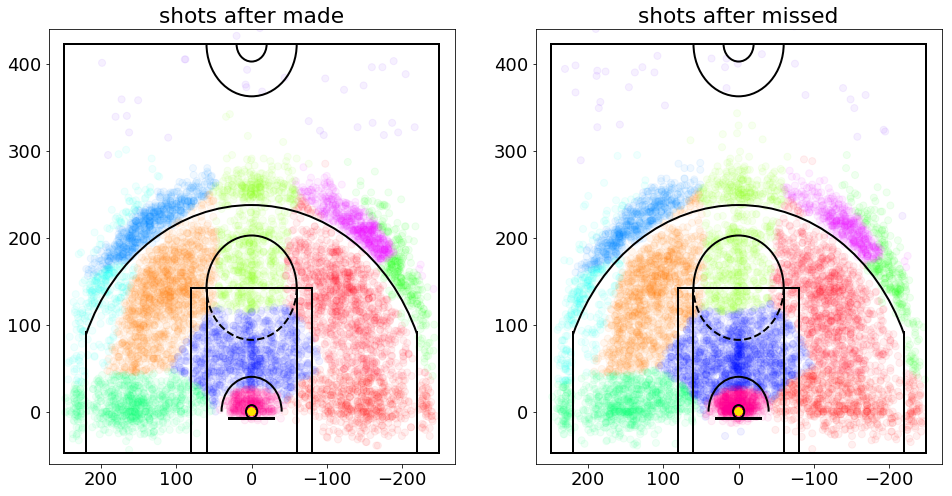

In [23]:
#%% let's try and visualize this - show scatter plot of after made and after missed shots
plt.rcParams['figure.figsize'] = (16, 8)

afterMissedData = data.iloc[afterMissedShotsList,:]
afterMadeData = data.iloc[afterMadeShotsList,:]

plt.figure();
plt.subplot(1,2,1); plt.title('shots after made')
plt.scatter(x=afterMadeData['loc_x'],y=afterMadeData['loc_y'],c=afterMadeData['shotLocationCluster'],s=50,cmap='hsv',alpha=0.06)
draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270);

plt.subplot(1,2,2); plt.title('shots after missed');
plt.scatter(x=afterMissedData['loc_x'],y=afterMissedData['loc_y'],c=afterMissedData['shotLocationCluster'],s=50,cmap='hsv',alpha=0.06)
draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270);

### Keen eyes can see differences in density here, but it's not very clear, so let's show the data in the gaussians format, hoping that it will be clearer

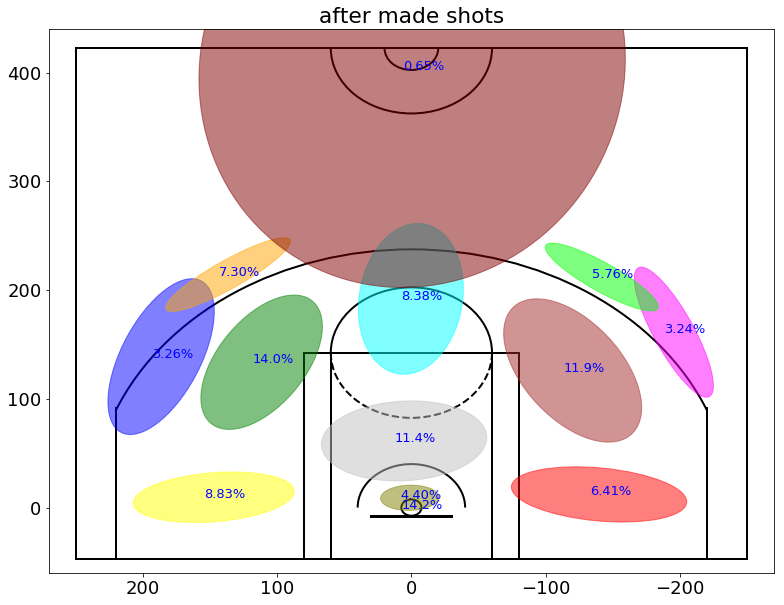

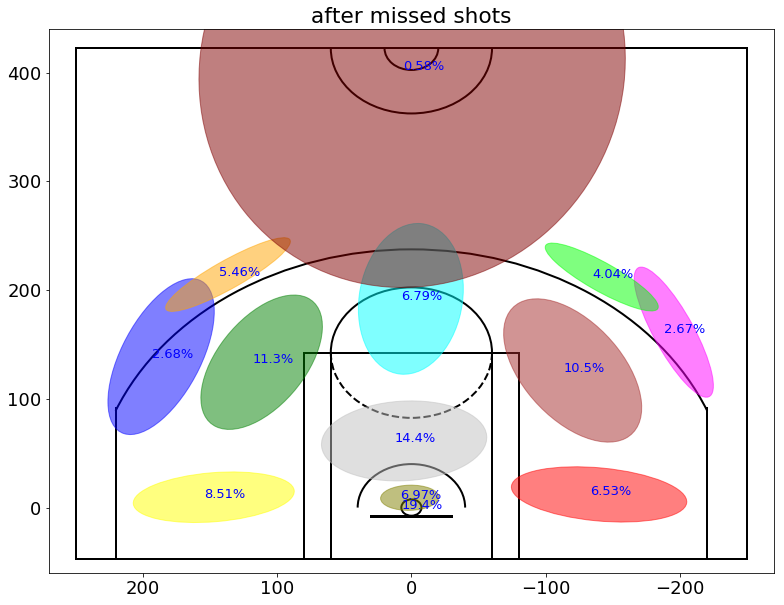

In [24]:
#%% show shot attempts of after made and after missed shots
plt.rcParams['figure.figsize'] = (13, 10)

variableCategories = afterMadeData['shotLocationCluster'].value_counts().index.tolist()
clusterFrequency = {}
for category in variableCategories:
    shotsAttempted = np.array(afterMadeData['shotLocationCluster'] == category).sum()
    clusterFrequency[category] = float(shotsAttempted)/afterMadeData.shape[0]

ellipseTextMessages = [str(100*clusterFrequency[x])[:4]+'%' for x in range(numGaussians)]
Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages)
draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270); plt.title('after made shots')

variableCategories = afterMissedData['shotLocationCluster'].value_counts().index.tolist()
clusterFrequency = {}
for category in variableCategories:
    shotsAttempted = np.array(afterMissedData['shotLocationCluster'] == category).sum()
    clusterFrequency[category] = float(shotsAttempted)/afterMissedData.shape[0]

ellipseTextMessages = [str(100*clusterFrequency[x])[:4]+'%' for x in range(numGaussians)]
Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages)
draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270); plt.title('after missed shots')

### Now it's very evident that after missing a shot, kobe is much more likely to throw directly from the basket relative to after making a shot (27% after missing the previous shot vs. 18% after making the previous shot) 

### It's also very evident that after making a shot, kobe is much more likely to try a 3 pointer as his next shot